In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import yaml
from copy import deepcopy
import h5py

from dataprocessing.streamlines_helpers import make_streamlines
from dataprocessing.equations_of_state import eos_water_density_IFC67, eos_water_enthalphy
from utils.visu_utils import _aligned_colorbar
from hyperparam_optuna import init_data
from utils import parse_args

In [6]:
%reload_ext autoreload
%autoreload 2

In [3]:
class NormalizeTransform:
    def __init__(self,info:dict,out_range = (0,1)):
        self.info = info
        self.out_min, self.out_max = out_range 

    def __call__(self,data, type = "Inputs"):
        for prop, stats in self.info[type].items():
            index = stats["index"]
            if index < data.shape[0]:
                self.__apply_norm(data,index,stats)
            else:
                print(f"Index {index} might be in training data but not in this dataset")
        return data
    
    def reverse(self,data,type = "Labels"):
        for prop, stats in self.info[type].items():
            index = stats["index"]
            self.__reverse_norm(data,index,stats)
        return data
    
    def __apply_norm(self,data,index,stats):
        norm = stats["norm"]
        
        def rescale():
            delta = stats["max"] - stats["min"]
            data[index] = (data[index] - stats["min"]) / delta * (self.out_max - self.out_min) + self.out_min
        
        if norm == "LogRescale":
            data[index] = np.log(data[index] - stats["min"] + 1)
            rescale()
        elif norm == "Rescale":
            rescale()
        elif norm == "Standardize":
            data[index] = (data[index] - stats["mean"]) / stats["std"]
        elif norm is None:
            pass
        else:
            raise ValueError(f"Normalization type '{stats['norm']}' not recognized")
        
    def __reverse_norm(self,data,index,stats):
        # if len(data.shape) == 4: # TODO not relevant for allin1 
        #     assert data.shape[0] <= data.shape[1], "Properties must be in 0th dimension; batches pushed to 1st dimension"
        norm = stats["norm"]

        def rescale():
            delta = stats["max"] - stats["min"]
            data[index] = (data[index] - self.out_min) / (self.out_max - self.out_min) * delta + stats["min"]

        if norm == "LogRescale":
            rescale()
            data[index] = np.exp(data[index]) + stats["min"] - 1
        elif norm == "Rescale":
            rescale()
        elif norm == "Standardize":
            data[index] = data[index] * stats["std"] + stats["mean"]
        elif norm is None:
            pass
        else:
            raise ValueError(f"Normalization type '{stats['Norm']}' not recognized")


In [4]:
inputs = torch.load("/scratch/sgs/pelzerja/datasets_prepared/allin1/dataset_large_square_6hp_varyK_1000dp inputs_pkixy outputs_t/Inputs/RUN_1.pt")
label = torch.load("/scratch/sgs/pelzerja/datasets_prepared/allin1/dataset_large_square_6hp_varyK_1000dp inputs_pkixy outputs_t/Labels/RUN_1.pt")
info = yaml.load(open("/scratch/sgs/pelzerja/datasets_prepared/allin1/dataset_large_square_6hp_varyK_1000dp inputs_pkixy outputs_t/info.yaml"), Loader=yaml.SafeLoader)
norm = NormalizeTransform(info)

In [5]:
inputs_unnormed = norm.reverse(deepcopy(inputs), "Inputs")

pressure_unnormed = inputs_unnormed[info["Inputs"]["Liquid Pressure [Pa]"]["index"]]
pressure_orig = torch.Tensor(np.array(h5py.File("/scratch/sgs/pelzerja/datasets/allin1/dataset_large_square_6hp_varyK_1000dp/RUN_1/pflotran.h5")['   4 Time  2.75000E+01 y']['Liquid Pressure [Pa]']).reshape((640,640),order="F"))
perm_unnormed = inputs_unnormed[info["Inputs"]["Permeability X [m^2]"]["index"]]
ids_unnormed = inputs_unnormed[info["Inputs"]["Material ID"]["index"]]
ids = inputs[info["Inputs"]["Material ID"]["index"]]
vx_unnormed = inputs_unnormed[info["Inputs"]["Liquid X-Velocity [m_per_y]"]["index"]]
vy_unnormed = inputs_unnormed[info["Inputs"]["Liquid Y-Velocity [m_per_y]"]["index"]]

temperature_unnormed = norm.reverse(deepcopy(label), "Labels")[0]

# Convert from meters per year to meters per second
vx_unnormed = vx_unnormed / (60*60*24*365.25)
vy_unnormed = vy_unnormed / (60*60*24*365.25)
[]

[]

Number of heat pumps:  6


Calculating streamlines: 100%|██████████| 6/6 [00:00<00:00, 73.02it/s]

Time for calculating streamlines:  0:00:00.089020  seconds
Time for drawing streamlines:  0:00:00.000771  seconds
Time for drawing streamlines:  0:00:00.000941  seconds


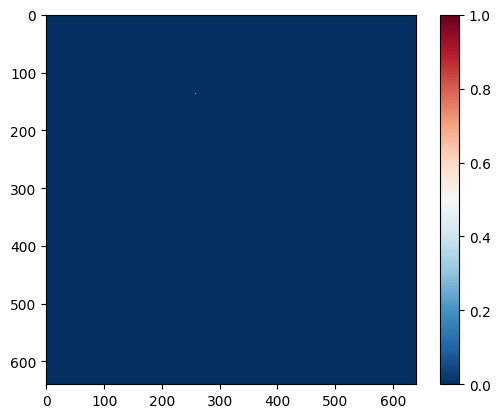

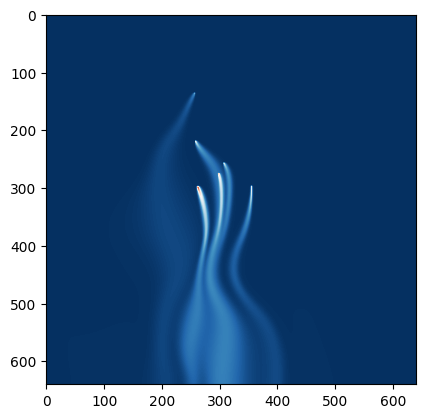

In [34]:
_, streamlines_faded = make_streamlines(mat_ids=ids_unnormed.numpy(), vx=vx_unnormed.numpy(), vy=vy_unnormed.numpy(), dims=ids_unnormed.shape)

plt.imshow(streamlines_faded,cmap="RdBu_r")
plt.colorbar()
plt.show()
plt.imshow(label[0], cmap="RdBu_r")

In [30]:
def energy_hps(ids, resolution, density):
    specific_heat_water = 4200 # [J/kgK]
    density_water = density # [kg/m^3]
    temp_diff = 5 # [K]
    volumetric_flow_rate = 0.00024 # [m^3/s]

    hp_energy = specific_heat_water * density_water * temp_diff * volumetric_flow_rate * 1/resolution**3
    hp_energy = hp_energy * ids

    kernel = torch.tensor([[-1,0,1],
                           [0,0,0],
                           [1,0,-1]],dtype=torch.float32)
    # kernel = torch.tensor([[0,0,0],
    #                        [0,1,0],
    #                        [0,0,0]],dtype=torch.float32)
    
    hp_energy = torch.nn.functional.conv2d(hp_energy.unsqueeze(0).unsqueeze(0), kernel.unsqueeze(0).unsqueeze(0), padding=1)

    return (hp_energy[0,0])

thermal_conductivity=1


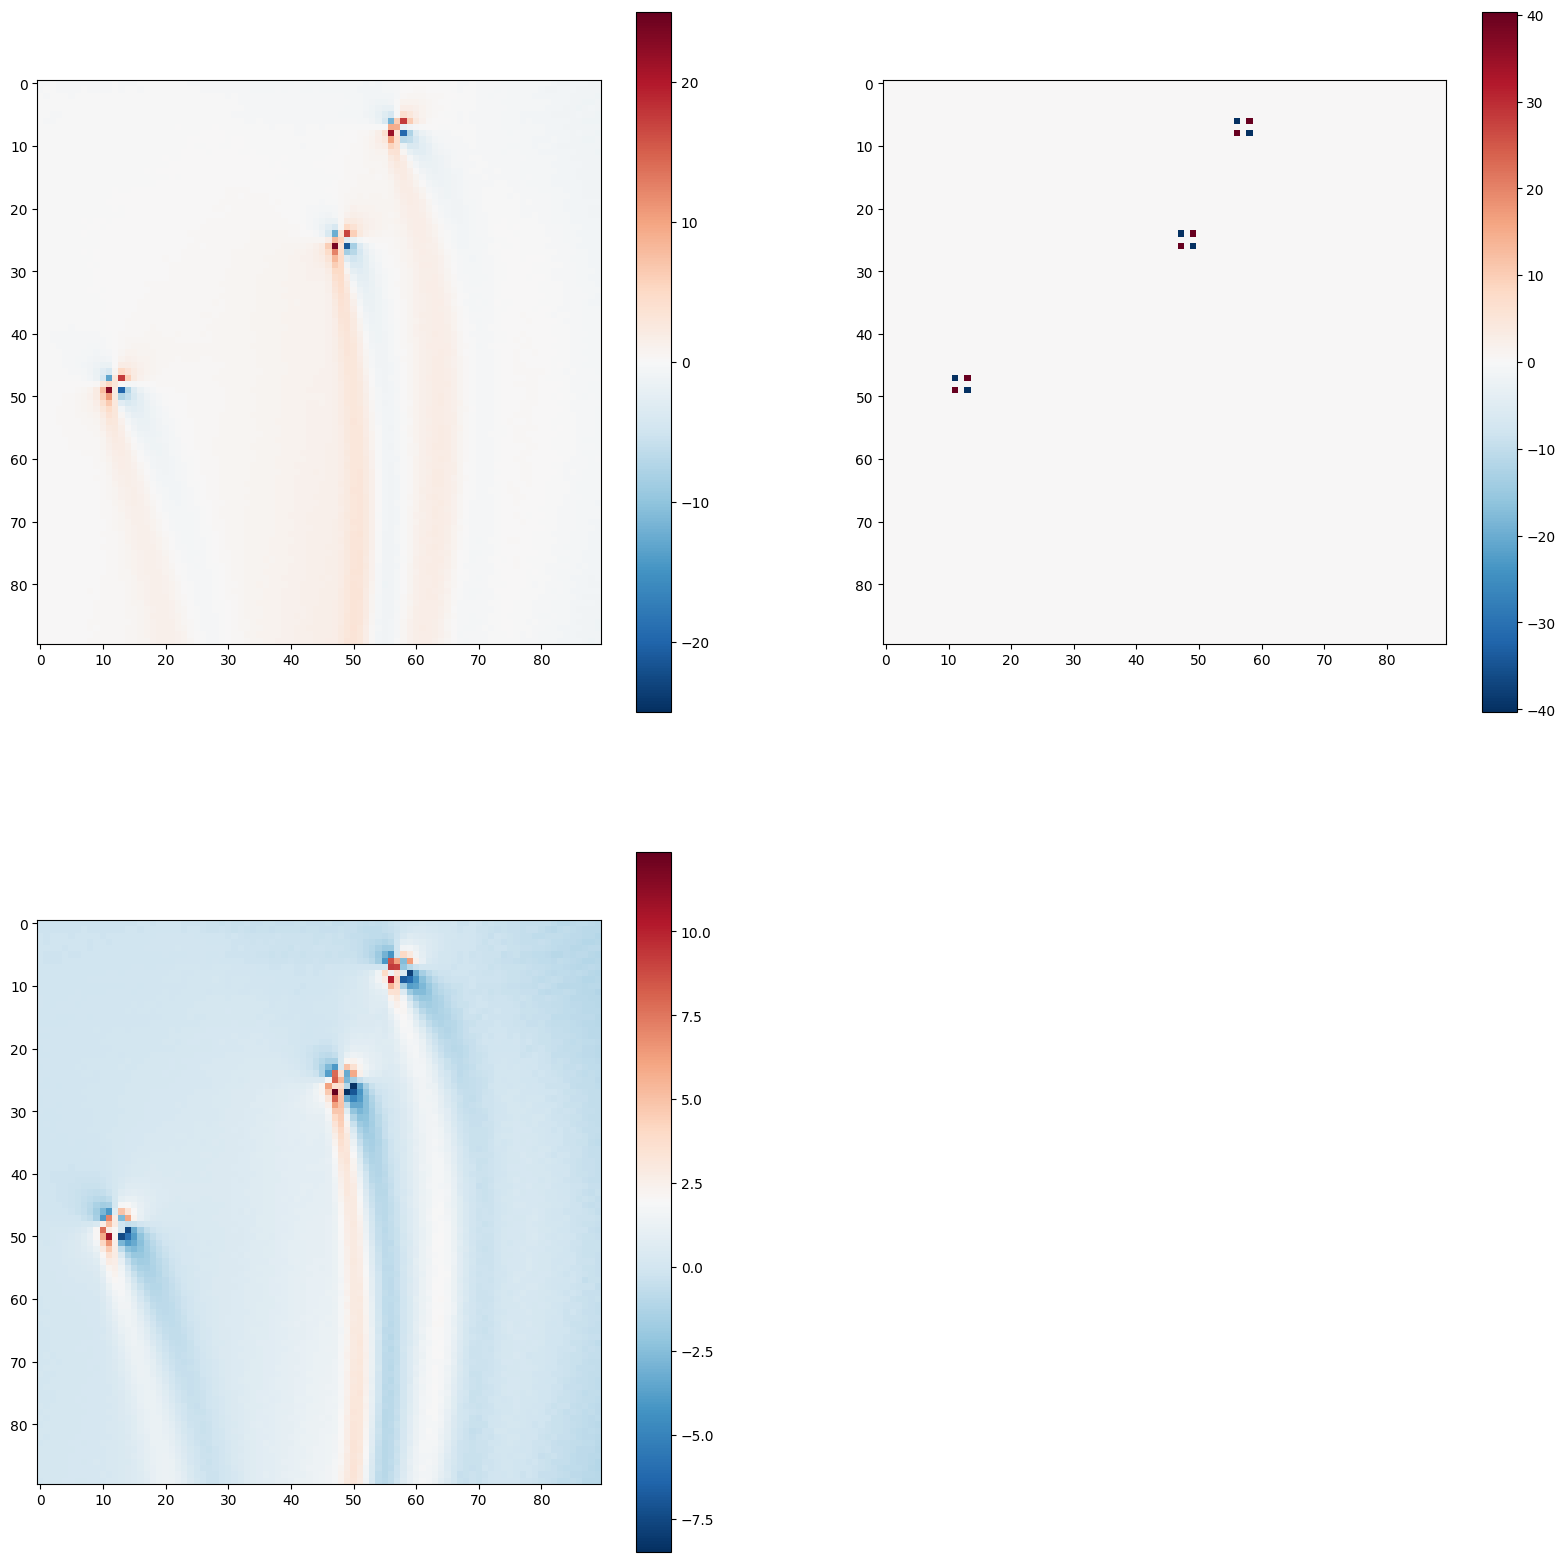

tensor(3.3783)


In [32]:
#  source: Manuel Hirche, 2023
resolution = 5. #m

# # Residual
# cond_dry = 0.65
# cond_sat = 1.0
# sl  = 1 #? saturation of liquid?

thermal_conductivity = 1 #cond_dry + torch.sqrt(sl) * (cond_sat - cond_dry)
print(f"{thermal_conductivity=}")

# pressure_unnormed = pressure_orig
density, molar_density = eos_water_density_IFC67(temperature_unnormed, pressure_unnormed)
enthalpy = eos_water_enthalphy(temperature_unnormed, pressure_unnormed)
T_grad = torch.gradient(temperature_unnormed)
energy_u = torch.gradient((molar_density * vx_unnormed * enthalpy) - (thermal_conductivity * T_grad[0]/resolution))[0]/resolution
energy_v = torch.gradient((molar_density * vy_unnormed * enthalpy) - (thermal_conductivity * T_grad[1]/resolution))[1]/resolution
energy = energy_u + energy_v
plt.figure(figsize=(20,20))
plt.subplot(2,2,1)
plt.imshow(energy[250:-300,250:-300],vmin=-25,vmax=25, cmap="RdBu_r")
plt.colorbar()
inflow_energy = energy_hps(ids, resolution, density)

plt.subplot(2,2,2)
plt.imshow(inflow_energy[250:-300,250:-300], cmap="RdBu_r")
plt.colorbar()

energy -= inflow_energy*0.5

plt.subplot(2,2,3)
plt.imshow(energy[250:-300,250:-300],vmin=-25,vmax=25, cmap="RdBu_r")
plt.colorbar()
plt.show()

energy_loss = torch.nn.MSELoss()(torch.Tensor(energy), torch.zeros_like(torch.Tensor(energy)))
print(energy_loss)

(638, 638)


/tmp/ipykernel_3269985/1025852821.py:14: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(inputs[1]), cmap="RdBu_r")


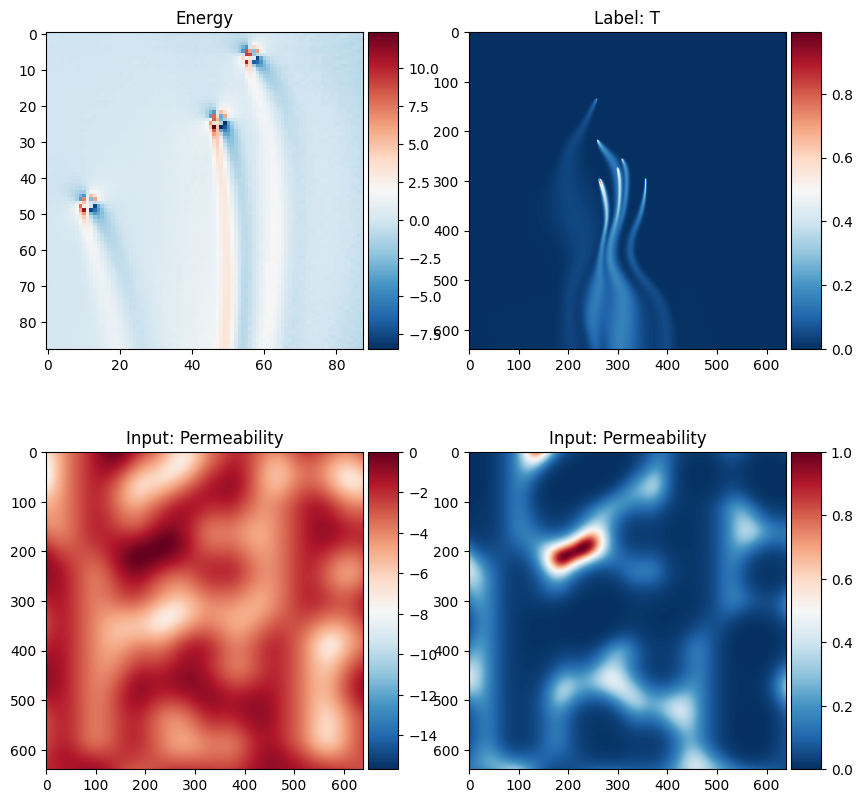

In [34]:
print(energy.shape)
boundary = 250
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Energy")
plt.imshow(energy[250:-300,250:-300], interpolation=None, cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,2)
plt.title("Label: T")
plt.imshow(label[0], cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,3)
plt.title("Input: Permeability")
plt.imshow(np.log(inputs[1]), cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,4)
plt.title("Input: Permeability")
plt.imshow(inputs[1], cmap="RdBu_r")
_aligned_colorbar()

(638, 638)


/tmp/ipykernel_3214644/1025852821.py:14: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(inputs[1]), cmap="RdBu_r")


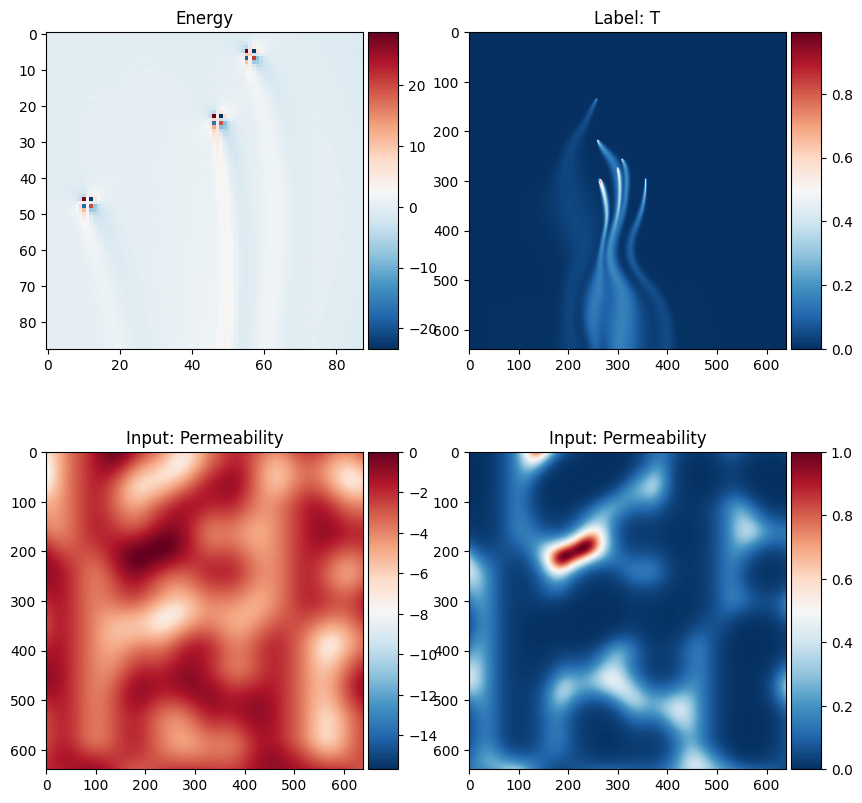

In [26]:
print(energy.shape)
boundary = 250
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("Energy")
plt.imshow(energy[250:-300,250:-300], interpolation=None, cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,2)
plt.title("Label: T")
plt.imshow(label[0], cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,3)
plt.title("Input: Permeability")
plt.imshow(np.log(inputs[1]), cmap="RdBu_r")
_aligned_colorbar()
plt.subplot(2,2,4)
plt.title("Input: Permeability")
plt.imshow(inputs[1], cmap="RdBu_r")
_aligned_colorbar()

# TODO add energy loss 

In [7]:
data_dir = "/scratch/sgs/pelzerja/datasets_prepared/allin1/dataset_large_square_6hp_varyK_1000dp inputs_pkixy outputs_t/"
image_dir = data_dir+"Inputs"
mask_dir  = data_dir+"Labels"
datasets, dataloaders = init_data(parse_args(), image_dir, mask_dir)

usage: ipykernel_launcher.py [-h]
                             [--subdomains_dist SUBDOMAINS_DIST SUBDOMAINS_DIST]
                             [--depth DEPTH] [--complexity COMPLEXITY]
                             [--kernel_size KERNEL_SIZE] [--padding PADDING]
                             [--comm COMM] [--num_comm_fmaps NUM_COMM_FMAPS]
                             [--num_epochs NUM_EPOCHS]
                             [--exchange_fmaps EXCHANGE_FMAPS]
                             [--batch_size_training BATCH_SIZE_TRAINING]
                             [--batch_size_testing BATCH_SIZE_TESTING]
                             [--num-convs NUM_CONVS] [--val_loss VAL_LOSS]
                             [--save_path SAVE_PATH]
ipykernel_launcher.py: error: unrecognized arguments: --f=/home/pelzerja/.local/share/jupyter/runtime/kernel-v33584154df74602f0af032bb573aa27db3bce3694.json


SystemExit: 2

/home/pelzerja/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3561: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
